## Trading The Bitcoin with the Money Flow Index Strategy:

I this study I will try to trade stocks with the Money Flow Index Strategy.It's a technical oscillator that uses price and volume data for identifying overbought or oversold signals in an asset. His range is between 0 and 100. We will see how the MFI indicator deals with assets as volatile as the Bitcoin. 

In [324]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
import yfinance as yf
import seaborn as sns

In [325]:
today=datetime.today().strftime("%Y-%m-%d")

The bitcoin USD ticker is "BTC-USD":

In [326]:
data=yf.download("BTC-USD", start="2018-01-01", end = today)
data.head(5)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-12-31,12897.700195,14377.400391,12755.599609,14156.400391,14156.400391,12136299520
2018-01-01,14112.200195,14112.200195,13154.700195,13657.200195,13657.200195,10291200000
2018-01-02,13625.000000,15444.599609,13163.599609,14982.099609,14982.099609,16846600192
2018-01-03,14978.200195,15572.799805,14844.500000,15201.000000,15201.000000,16871900160
2018-01-04,15270.700195,15739.700195,14522.200195,15599.200195,15599.200195,21783199744


Let's have a brief overview of the Close Price history:

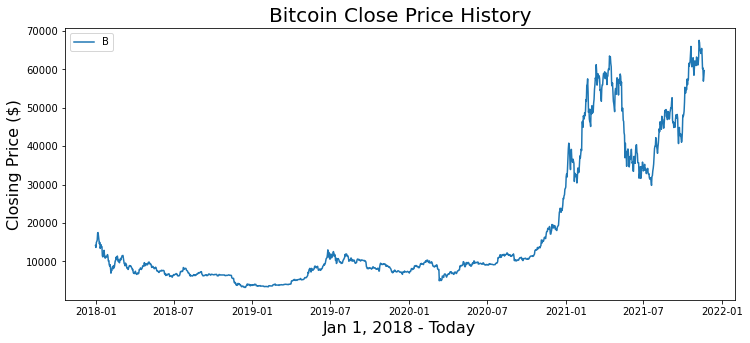

In [343]:
plt.figure(figsize=(12,5))
plt.plot(data["Close"])
plt.title("Bitcoin Close Price History", fontsize=20)
plt.xlabel("Jan 1, 2018 - Today", fontsize=16)
plt.ylabel("Closing Price ($)",fontsize=16)
plt.legend("BTC",loc="upper left")

plt.show()

I will create a function for the Money Flow Index :

In [328]:
def MFI(data, High, Low, Close, Volume, period):
    Positive_MF=[]
    Negative_MF=[]
    positive_mf=[]
    negative_mf=[]
    
    typical_price=((data[High]+data[Low]+data[Close])/3)
    data["Typical Price"]=typical_price
    data["Raw Money Flow"]=data[Volume]*data["Typical Price"]
    for i in range(len(data["Raw Money Flow"])):
        if data["Raw Money Flow"][i]>=data["Raw Money Flow"][i-1]:
            Positive_MF.append(data["Raw Money Flow"][i-1])
            Negative_MF.append(0)
        else :
            Negative_MF.append(data["Raw Money Flow"][i-1])
            Positive_MF.append(0)
    for i in range(period-1, len(Positive_MF)):
        positive_mf.append(sum(Positive_MF[i-period+1:i+1]))
    for i in range(period-1, len(Negative_MF)):
        negative_mf.append(sum(Negative_MF[i-period+1:i+1]))
    MFR=np.array(positive_mf)/np.array(negative_mf)
    data["Money Flow Ratio"]=np.concatenate([np.zeros(period-1),MFR])
    MFI=100-(100/(1+MFR))
    data["Money Flow Index"]=np.concatenate([np.zeros(period-1),MFI])



    

In [329]:
MFI(data=data, High="High", Low="Low", Close="Close", Volume="Volume", period=14)

In [330]:
data.tail(5)

,Open,High,Low,Close,Adj Close,Volume,Typical Price,Raw Money Flow,Money Flow Ratio,Money Flow Index
Date,,,,,,,,,,
2021-11-16,63721.195312,63721.195312,59016.335938,60161.246094,60161.246094,46844335592,60966.259115,2.855924e+15,0.533537,34.791275
2021-11-17,60139.621094,60823.609375,58515.410156,60368.011719,60368.011719,39178392930,59902.343750,2.346878e+15,0.520872,34.248238
2021-11-18,60360.136719,60948.500000,56550.792969,56942.136719,56942.136719,41388338699,58147.143229,2.406614e+15,0.713165,41.628520
2021-11-19,56896.128906,58351.113281,55705.179688,58119.578125,58119.578125,38702407772,57391.957031,2.221207e+15,0.698259,41.116164
2021-11-20,58115.082031,59859.878906,57469.726562,59697.195312,59697.195312,30624264863,59008.933594,1.807105e+15,0.685842,40.682455


An MFI reading above 80 is considered overbought and an MFI reading below 20 is considered oversold, although levels of 90 and 10 are also used as thresholds.  

NB:Due to an unexplainable bug occuring, I can't run a buy or sell array with all its elements NaN(Not a number), so just for the case study I will lower the selling threshold to 70 instead of 80 in the last graph(thank you for your understanding).

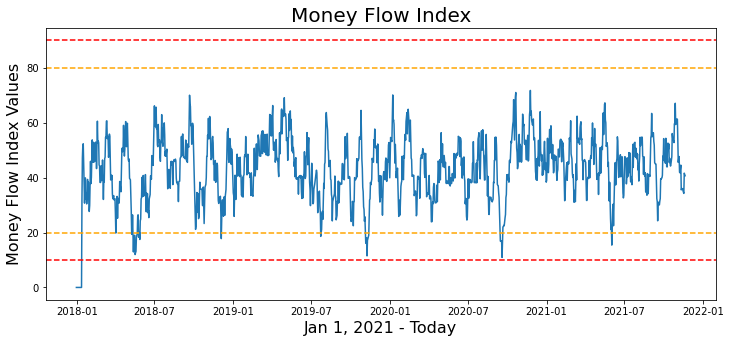

In [340]:
plt.figure(figsize=(12,5))
plt.plot(data["Money Flow Index"])
plt.title("Money Flow Index", fontsize=20)
plt.xlabel("Jan 1, 2021 - Today", fontsize=16)
plt.ylabel("Money Flow Index Values",fontsize=16)
plt.axhline(10, linestyle='--', color='red')
plt.axhline(90, linestyle='--', color='red')
plt.axhline(20, linestyle='--', color='orange')
plt.axhline(80, linestyle='--', color='orange')

plt.show()

In [332]:
def signal(data, high, low):
    buy=[]
    sell=[]
    
    for i in range(len(data["Money Flow Index"])):
        if data["Money Flow Index"][i]>high:
            buy.append(np.nan)
            sell.append(data["Close"][i])
        elif data["Money Flow Index"][i]<low:
            buy.append(data["Close"][i])
            sell.append(np.nan)
        else:
            buy.append(np.nan)
            sell.append(np.nan)
    return buy, sell
            
            

I delete all the period-1 values because the buy signals were only due to the period-1 values (which zeros)  I added to the MFR column to be able to merge it with the DataFrame.

In [344]:
df=data.copy()
df["Buy"]=signal(df,70,20)[0]
df["Sell"]=signal(df, 70,20)[1]
df["Buy"][:period-1]=np.nan
df

<ipython-input-344-fde74ad10b8b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Buy"][:period-1]=np.nan
C:\Users\DELL\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Open,High,Low,Close,Adj Close,Volume,Typical Price,Raw Money Flow,Money Flow Ratio,Money Flow Index,Buy,Sell
Date,,,,,,,,,,,,
2017-12-31,12897.700195,14377.400391,12755.599609,14156.400391,14156.400391,12136299520,13763.133464,1.670335e+14,0.000000,0.000000,NaN,NaN
2018-01-01,14112.200195,14112.200195,13154.700195,13657.200195,13657.200195,10291200000,13641.366862,1.403860e+14,0.000000,0.000000,NaN,NaN
2018-01-02,13625.000000,15444.599609,13163.599609,14982.099609,14982.099609,16846600192,14530.099609,2.447828e+14,0.000000,0.000000,NaN,NaN
2018-01-03,14978.200195,15572.799805,14844.500000,15201.000000,15201.000000,16871900160,15206.099935,2.565558e+14,0.000000,0.000000,NaN,NaN
2018-01-04,15270.700195,15739.700195,14522.200195,15599.200195,15599.200195,21783199744,15287.033529,3.330005e+14,0.000000,0.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-16,63721.195312,63721.195312,59016.335938,60161.246094,60161.246094,46844335592,60966.259115,2.855924e+15,0.533537,34.791275,NaN,NaN
2021-11-17,60139.621094,60823.609375,58515.410156,60368.011719,60368.011719,39178392930,59902.343750,2.346878e+15,0.520872,34.248238,NaN,NaN
2021-11-18,60360.136719,60948.500000,56550.792969,56942.136719,56942.136719,41388338699,58147.143229,2.406614e+15,0.713165,41.628520,NaN,NaN


Let's take a look on the buy and sell signals:

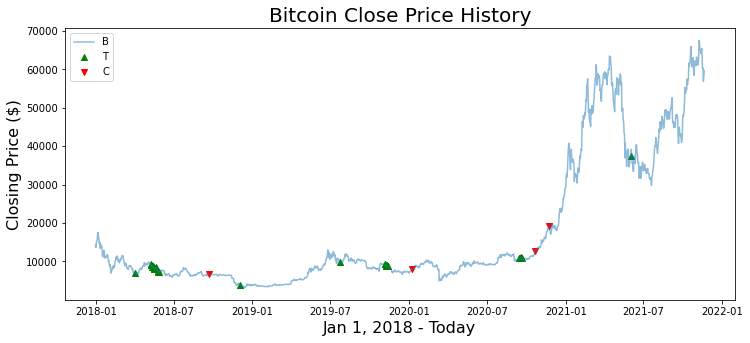

In [342]:
plt.figure(figsize=(12,5))
plt.plot(df["Close"], label = "Close Price", alpha =0.5)
plt.scatter(data.index, df["Buy"], color="green", label="Buy Signal", marker="^", alpha=1)
plt.scatter(data.index, df["Sell"], color="red", label="Sell Signal", marker="v", alpha=1)
plt.title("Bitcoin Close Price History", fontsize=20)
plt.xlabel("Jan 1, 2018 - Today", fontsize=16)
plt.ylabel("Closing Price ($)",fontsize=16)
plt.legend("BTC",loc="upper left")

plt.show()